In [1]:
! pip install datasets

In [2]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [3]:
! pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7bab380865303f1daf2c06e87b987dd2e85d5358fe4f182b0927d65b0e66202c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
! pip install moverscore

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for moverscore: filename=moverscore-1.0.3-py3-none-any.whl size=7950 sha256=77d52fd18b3a063c0df69eb5c7961d64f12eca7433f62e5065f57f0b881cfefb
  Stored in directory: /root/.cache/pip/wheels/ae/b5/15/116944664c4dc1bc5316f63395d0ca11d325364b44112eb381
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=128f37cbbfd568263ed8e5a13ad919490f4879986909c7311bf6926b76b50219
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built moverscore typing


In [5]:
import os

import pandas as pd

import torch

import psutil

import pprint

import evaluate

import numpy as np

#from moverscore import MoverScore - ошибка в коде установки, так как что-то внутри там со старыми библиотеками, а жаль, хотела использовать



from transformers import (

    T5Tokenizer,

    LongT5ForConditionalGeneration,

    TrainingArguments,

    Trainer,

    pipeline,

    DataCollatorForSeq2Seq,

    EarlyStoppingCallback

)

from datasets import load_dataset, Dataset

from tqdm.auto import tqdm

import matplotlib.pyplot as plt



import warnings

warnings.filterwarnings('ignore')

Для начала загрузим датасет. Я выбрала Xsum. Тут статьи из новостей BBC. Суммаризация всего 1-2 предложения.

In [6]:
dataset = load_dataset('EdinburghNLP/xsum')

dataset

0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

Оценим на количество текстов до сортировки по токенам. В целом хорошо, можно двигаться дальше.

In [7]:
df = pd.DataFrame(dataset['train'])

print('Total rows:', len(df))

Total rows: 204045


In [8]:
tokenizer = T5Tokenizer.from_pretrained('google/long-t5-tglobal-base')

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Тут делаем фильтрацию. Нужно чтобы было не менее 1024 токена в одном документе. Займёт время (минут 15). Надеюсь, что по итогу будет нужное количество данных.

In [9]:
def filter_by_length(example):

    tokens = tokenizer.encode(example['document'], truncation=False)

    return len(tokens) >= 1024



train_dataset = dataset['train'].filter(filter_by_length).select(range(10000))

test_dataset = dataset['test'].filter(filter_by_length)

validation_dataset = dataset['validation'].filter(filter_by_length)

Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Данных тренировочных 10тыс. => препроцессинг завершён.



UPD: Начались проблемы с памятью и нехваткой GPU. Поскольку мне надо предоставить какие-то результаты, чтобы это работало и gpu хватало, я решила уменьшить в 2 раза количество текстов. Я понимаю, что это не соответствует заданию, но, на мой взгляд, лучше я покажу хоть какие-то результаты на минимальных данных, чем вообще ничего по результатам не будет.

In [10]:
train_dataset = train_dataset.select(range(5000))

In [11]:
len(train_dataset)

5000

Не забываем про модель.

In [12]:
model = LongT5ForConditionalGeneration.from_pretrained('google/long-t5-tglobal-base')

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [12]:
pipe = pipeline('summarization', model='google/long-t5-tglobal-base', device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Теперь делаем инференс. Я люблю понимать, сколько по времени займёт всё, поэтому использую progress bar.

In [13]:
def generate_summaries(dataset, batch_size=8):

    summaries = []

    total_batches = len(dataset) // batch_size + (1 if len(dataset) % batch_size != 0 else 0) #Тут посчитаем количество батчей



    for i in tqdm(range(0, len(dataset), batch_size), desc='Идёт генерация', total=total_batches):

        batch = dataset[i:i + batch_size]['document']

        batch_summaries = pipe(batch)

        summaries.extend([summary['summary_text'] for summary in batch_summaries])



    return summaries

In [14]:
test_summaries = generate_summaries(test_dataset)

Идёт генерация:   0%|          | 0/154 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [15]:
validation_summaries = generate_summaries(validation_dataset)

Идёт генерация:   0%|          | 0/153 [00:00<?, ?it/s]

Теперь посмотрим на метрики. Воспользуемся Rouge, которая основывается на вычислении оценок precision (насколько большая часть сгенерированного текста совпадает с эталонным) и recall (насколько большая часть эталонного текста совпадает с сгенерированным текстом). Посмотрим, насколько изначальное резюме соответствует сгенерированному.

In [41]:
rouge_score = evaluate.load("rouge")

In [17]:
scores_test = rouge_score.compute(

    predictions=test_summaries, references=test_dataset['summary']

)

scores_test

{'rouge1': 0.12703769571625706,
 'rouge2': 0.014161413070513862,
 'rougeL': 0.10051017656649419,
 'rougeLsum': 0.1004866413310938}

In [18]:
scores_valid = rouge_score.compute(

    predictions=validation_summaries, references=validation_dataset['summary']

)

scores_valid

{'rouge1': 0.12491227001846092,
 'rouge2': 0.01296452402352468,
 'rougeL': 0.09979975977428862,
 'rougeLsum': 0.09980169520473144}

Выглядит не очень хорошо. Разница между test и valid не очень большая.

In [46]:
from nltk.translate.bleu_score import corpus_bleu

In [47]:
def compute_corpus_bleu(references, summaries):

    reference_lists = [[ref.split() for ref in ref_group] for ref_group in references]

    summary_lists = [summary.split() for summary in summaries]



    bleu_score = corpus_bleu(reference_lists, summary_lists)



    return bleu_score

In [21]:
average_bleu_score_test = compute_corpus_bleu(test_dataset['summary'], test_summaries)

In [22]:
average_bleu_score_test

6.957886396759731e-232

In [23]:
average_bleu_score_valid = compute_corpus_bleu(validation_dataset['summary'], validation_summaries)

In [24]:
average_bleu_score_valid

6.84192335795953e-232

Оба значение маленькие. Это плохо. Значит, что мало сходства. Разница тоже между ними не очень большая.

Надо улучшать, пэтому начнём обучение.



Надо подготовить данные для модели, чтобы всё было хорошо. Нужна токенизация и Dataloader. Пишу функцией, так как надо потом тестовые и валидационные через это пропускать. Максимальную длину текста возьму из минимально возможной. В задании сказано, что нужно не менее 1024, следовательно 1024 можно использовать. Иначе код совсем не запускается. Так еслть хотя бы шанс что-то запустить.

In [13]:
MAX_LEN = 1024

SUMMARY_LEN = 512

Функция препроцессинга, где мы подготавливаем код. Вводим инпут и целевое summary, ограничиваем длину

In [14]:
def preprocess_function(examples):

    inputs = examples['document']

    targets = examples['summary']

    model_inputs = tokenizer(

        inputs,

        max_length=MAX_LEN,

        truncation=True,

        padding='max_length'

    )



    labels = tokenizer(

        text_target=targets,

        max_length=SUMMARY_LEN,

        truncation=True,

        padding='max_length'

    )



    model_inputs['labels'] = labels['input_ids'] #Токены, которые модель будет использовать

    #Модель будет понимать, какие токены она должна предсказать на выходе

    return model_inputs

In [15]:
tokenized_train = train_dataset.map(

    preprocess_function,

    batched=True,

    num_proc=4

)

tokenized_valid = validation_dataset.map(

    preprocess_function,

    batched=True,

    num_proc=4

)

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1223 [00:00<?, ? examples/s]

Подготваливаем данные в батчах

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Переносим

In [17]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

LongT5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): LongT5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): LongT5Block(
        (layer): ModuleList(
          (0): LongT5LayerTransientGlobalSelfAttention(
            (TransientGlobalSelfAttention): LongT5TransientGlobalAttention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
              (global_relative_attention_bias): Embedding(32, 12)
              (global_input_layer_norm): LongT5LayerNorm()
            )
            (layer_norm): LongT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): LongT5LayerFF(
            (DenseReluDense

Здесь начинаем обучать модель. Возьму 2 эпохи для теста, минимальный размер батча и побольше gradient_accumulation_steps. Ценим gpu на вес золота, так как вот такое стандартная реакция при выполнении этого дз:




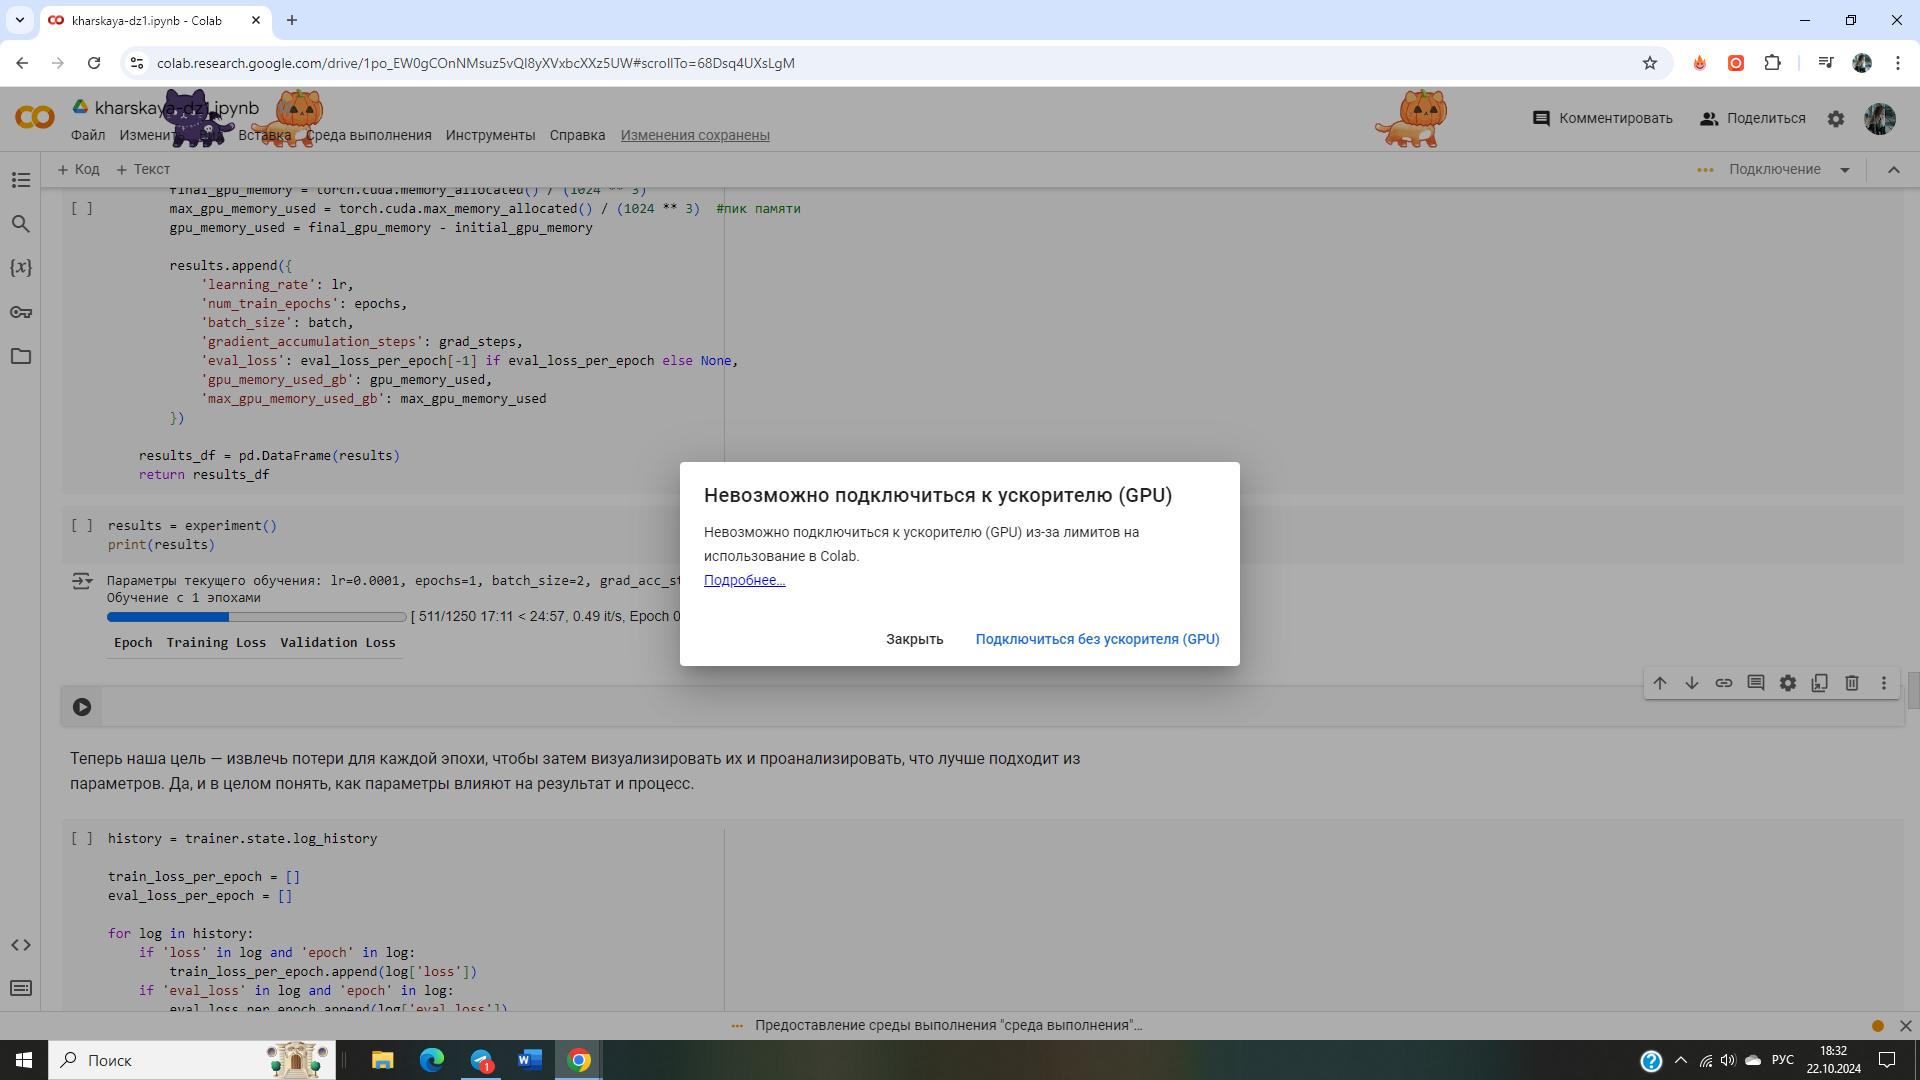

UPD: При первом единичном обучении с 2-мя эпохами я забыла поставить сохранение и заметила только в самом конце обучения. Именно по этой причине там не будут построены графики, так как их просто не начем строить. Но метрики посчитаю!

In [21]:
def train_model(learning_rate=1e-8, num_train_epochs=1, batch_size=1, gradient_accumulation_steps=1):

    training_args = TrainingArguments(

        output_dir='./results',

        eval_strategy='epoch',

        save_strategy='epoch',

        learning_rate=learning_rate,

        per_device_train_batch_size=batch_size,

        per_device_eval_batch_size=batch_size,

        num_train_epochs=num_train_epochs,

        weight_decay=0.01,

        logging_dir='./logs',

        logging_first_step=True,

        logging_strategy="epoch",

        report_to="tensorboard",

        gradient_accumulation_steps=gradient_accumulation_steps,

        fp16=torch.cuda.is_available(),

        load_best_model_at_end=True,

        metric_for_best_model="eval_loss",

        greater_is_better=False

    )



    trainer = Trainer(

        model=model,

        args=training_args,

        train_dataset=tokenized_train,

        eval_dataset=tokenized_valid,

        tokenizer=tokenizer,

        data_collator=data_collator,

        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

    )



    print(f"Обучение с {num_train_epochs} эпохами")

    trainer.train()

    trainer.save_model(f'./fine-tuned-longt5-{num_train_epochs}epochs-{learning_rate}lr')

    return trainer

In [35]:
trainer = train_model(

    learning_rate=1e-8,

    num_train_epochs=2,

    batch_size=1,

    gradient_accumulation_steps=8 #не хочу брать больше, так как по времени будет вообще не эффективно

)

Обучение с 2 эпохами


Epoch,Training Loss,Validation Loss
1,1507270646872011.500000,nan
2,351068592678528.625000,nan


In [36]:
def generate_summaries_after_training(model, tokenizer, dataset, batch_size=8, max_length=512):

    summaries = []

    total_batches = len(dataset) // batch_size + (1 if len(dataset) % batch_size != 0 else 0)



    for i in tqdm(range(0, len(dataset), batch_size), desc='Идёт генерация', total=total_batches):

        batch = dataset[i:i + batch_size]['document']



        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)



        input_ids = inputs['input_ids'].to(model.device)

        attention_mask = inputs['attention_mask'].to(model.device)



        with torch.no_grad():

            summary_ids = model.generate(

                input_ids=input_ids,

                attention_mask=attention_mask,

                max_length=512,

                early_stopping=True

            )



        batch_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)



        summaries.extend(batch_summaries)



    return summaries

In [37]:
trained_model = trainer.model

trained_tokenizer = trainer.tokenizer

In [40]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, test_dataset)

validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, validation_dataset)

Идёт генерация:   0%|          | 0/154 [00:00<?, ?it/s]

Идёт генерация:   0%|          | 0/153 [00:00<?, ?it/s]

In [41]:
scores_test = rouge_score.compute(

    predictions=test_summaries, references=test_dataset['summary']

)

print(scores_test)

{'rouge1': 0.1702280511202074, 'rouge2': 0.02425578536856924, 'rougeL': 0.1207274248842918, 'rougeLsum': 0.12041646635519099}


In [42]:
scores_valid = rouge_score.compute(

    predictions=validation_summaries, references=validation_dataset['summary']

)

print(scores_valid)

{'rouge1': 0.1672494139206152, 'rouge2': 0.022485277771976536, 'rougeL': 0.11969688548917232, 'rougeLsum': 0.11974360414750126}


In [43]:
average_bleu_score_test = compute_corpus_bleu(test_dataset['summary'], test_summaries)

print("BLEU (тест):", average_bleu_score_test)

BLEU (тест): 6.526146070970134e-232


In [44]:
average_bleu_score_valid = compute_corpus_bleu(validation_dataset['summary'], validation_summaries)

print("BLEU (валид):", average_bleu_score_valid)

BLEU (валид): 6.610892296503915e-232


Вспомним, что было до обучения:

Тест:

```

{'rouge1': 0.12703769571625706,

 'rouge2': 0.014161413070513862,

 'rougeL': 0.10051017656649419,

 'rougeLsum': 0.1004866413310938}

```



Валид:

```

{'rouge1': 0.12491227001846092,

 'rouge2': 0.01296452402352468,

 'rougeL': 0.09979975977428862,

 'rougeLsum': 0.09980169520473144}

```



 6.957886396759731e-232 - тест



 6.84192335795953e-232 - валид



 В итоге, результат лучше не стал. Так и остался примерно на таком же уровне. Всё было зря...

Вот тут перехожу на kaggle. Модель сохранена та, которую дообучила. Не все ячейки кода буду перезапускать на kaggle, чтобы не тратить время.



----------------------------------------------

In [31]:
# !pip install git+https://github.com/ThomasScialom/QuestEval.git Опять-таки хотела ещё вот такую метрику посчитать, но с установкой сложности...

In [18]:
! pip install optuna

In [19]:
from optuna import create_study

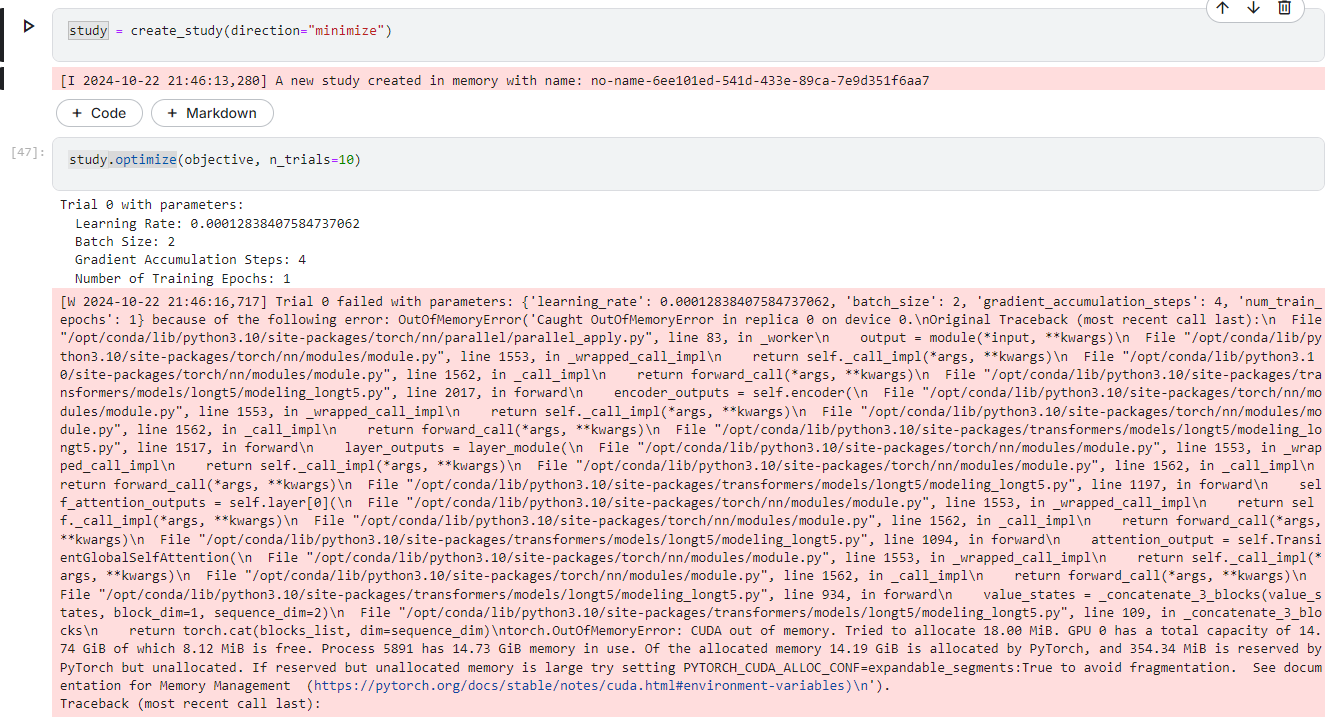

первый запуск вышел неудачным. Сокращаем батч до 1.

In [20]:
def get_memory_usage():
    if torch.cuda.is_available():  # GPU
        torch.cuda.synchronize()
        current_gpu_memory = torch.cuda.memory_allocated() / (1024 ** 3)
        max_gpu_memory = torch.cuda.max_memory_allocated() / (1024 ** 3)  # пик
        return current_gpu_memory, max_gpu_memory
    else:  # CPU
        memory_info = psutil.virtual_memory()
        current_cpu_memory = memory_info.used / (1024 ** 3)
        return current_cpu_memory, None

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #ROUGE
    result = rouge_score.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=['rouge1', 'rouge2', 'rougeL']
    )

    #BLEU
    bleu_metric = load_metric("bleu")
    bleu_result = bleu_metric.compute(predictions=[pred.split() for pred in decoded_preds],
                                       references=[[label.split()] for label in decoded_labels])
    result['bleu'] = bleu_result['bleu']

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [22]:
def preprocess_logits_for_metrics(logits, labels): #это логи
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

In [23]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 3e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1])
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [4, 15])
    num_train_epochs = trial.suggest_int('num_train_epochs', low=1, high=1)

    print(f"Trial {trial.number} with parameters:")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Gradient Accumulation Steps: {gradient_accumulation_steps}")
    print(f"  Number of Training Epochs: {num_train_epochs}")

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy='epoch',
        eval_steps=200,
        save_strategy='epoch',
        save_total_limit=2,
        report_to='tensorboard',
        learning_rate=learning_rate,
        dataloader_num_workers=4,
        fp16=True,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        compute_metrics=compute_metrics
    )

    #начальное использование памяти
    initial_memory, _ = get_memory_usage()

    trainer.train()

    #финальное использование памяти
    final_memory, max_memory = get_memory_usage()

    memory_used = final_memory - initial_memory

    eval_results = trainer.evaluate(eval_dataset=tokenized_valid)

    print(f'Использование памяти (GB): {memory_used:.2f}')
    
    return eval_results["eval_loss"], memory_used

In [24]:
study = create_study(direction="minimize")

[I 2024-10-22 22:38:36,689] A new study created in memory with name: no-name-02ca3149-1b2c-4e57-8f02-3438dd2b7386


In [25]:
study.optimize(objective, n_trials=10)

Trial 0 with parameters:
  Learning Rate: 0.0002402043461215882
  Batch Size: 1
  Gradient Accumulation Steps: 15
  Number of Training Epochs: 1


Epoch,Training Loss,Validation Loss


[W 2024-10-22 23:11:37,279] Trial 0 failed with parameters: {'learning_rate': 0.0002402043461215882, 'batch_size': 1, 'gradient_accumulation_steps': 15, 'num_train_epochs': 1} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 4.78 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.59 GiB is free. Process 2177 has 10.15 GiB memory in use. Of the allocated memory 8.37 GiB is allocated by PyTorch, and 1.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_30/190464957.py", line 44, in objective
    trainer.train()
  File "

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.78 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.59 GiB is free. Process 2177 has 10.15 GiB memory in use. Of the allocated memory 8.37 GiB is allocated by PyTorch, and 1.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Идея была хорошей и я почти поверила в её реализацию, но cuda вновь сказала нет. Причём оно уже обучилось! Оставлю такой результат здесь. Код хороший, как мне кажется, просто проблема в ограниченности ресурсов.

Запустим последний раз в надежде, что обучение пройдёт хорошо.

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_results = rouge_metric.compute(predictions=predictions, references=labels, use_aggregator=True)
    bleu_results = bleu_metric.compute(predictions=predictions, references=labels)

    return {
        "eval/rougeL": rouge_results["rougeL"].mid.fmeasure,
        "eval/bleu": bleu_results["bleu"],
    }

In [27]:
def train_model(learning_rate=1e-8, num_train_epochs=1, batch_size=1, gradient_accumulation_steps=1):

    training_args = TrainingArguments(

        output_dir='./results',

        eval_strategy='epoch',

        save_strategy='epoch',

        learning_rate=learning_rate,

        per_device_train_batch_size=batch_size,

        per_device_eval_batch_size=batch_size,

        num_train_epochs=num_train_epochs,

        weight_decay=0.01,

        logging_dir='./logs',

        logging_first_step=True,

        logging_strategy="epoch",

        report_to="tensorboard",

        gradient_accumulation_steps=gradient_accumulation_steps,

        fp16=torch.cuda.is_available(),

        load_best_model_at_end=True,

        metric_for_best_model="eval_loss",

        greater_is_better=False

    )



    trainer = Trainer(

        model=model,

        args=training_args,

        train_dataset=tokenized_train,

        eval_dataset=tokenized_valid,

        tokenizer=tokenizer,

        data_collator=data_collator,

        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

    )



    print(f"Обучение с {num_train_epochs} эпохами")

    memory_before = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память до обучения: {memory_before:.2f} MB")

    trainer.train()

    memory_after = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память после обучения: {memory_after:.2f} MB")


    trainer.save_model(f'./fine-tuned-longt5-{num_train_epochs}epochs-{learning_rate}lr')

    return trainer

In [28]:
trainer = train_model(

    learning_rate=1e-8,

    num_train_epochs=1,

    batch_size=1,

    gradient_accumulation_steps=8

)

Обучение с 1 эпохами
Память до обучения: 3080.91 MB


Epoch,Training Loss,Validation Loss
0,54.490200,59.446144


Память после обучения: 3045.51 MB


Построим графики. На этот раз всё должно сохранится в tensoreboard

In [29]:
from tensorboard.backend.event_processing import event_accumulator

In [30]:
event_acc = event_accumulator.EventAccumulator('./logs')

event_acc.Reload()

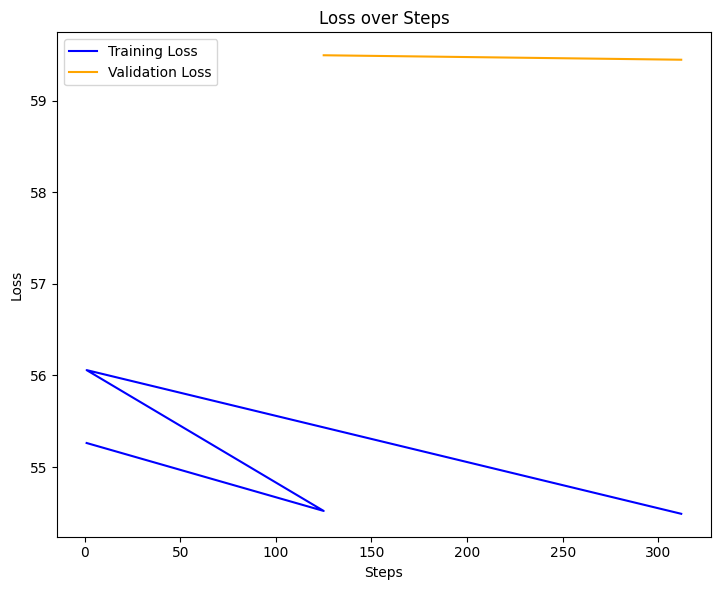

In [33]:
losses = event_acc.Scalars('train/loss')
eval_losses = event_acc.Scalars('eval/loss')

train_df = pd.DataFrame(losses)
eval_df = pd.DataFrame(eval_losses)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_df['step'], train_df['value'], label='Training Loss', color='blue')
plt.plot(eval_df['step'], eval_df['value'], label='Validation Loss', color='orange')
plt.title('Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.show()

Да, график странный. Тренировочные потери колеблются, это указывает на неустойчивый процесс обучения. Параметры подобраны не самым лучшим образом и это понятно. Тренировочные примеры и так сокращены, чтобы не было проблем с памятью и хватало gpu. Все остальные параметры приходится брать по минимуму, чтобы "влезть" (эпохи, размер батча), другие же надо наоборот увеличивать (gradient_accumulation_steps), чтобы снизить нагрузку на память. Из-за этого вот такие результаты получаются плохие.

Также хочу отметить, что я обрезала до 1024 токенов инпуты. Это тоже не самый лучший вариант, ведь тексты больше тоже есть. Получается, что теряем важную информацию. Соответственно из-за этого обучение тоже идёт не в ту сторону. 

In [39]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, test_dataset)

Идёт генерация:   0%|          | 0/154 [00:00<?, ?it/s]

In [42]:
scores_test = rouge_score.compute(

    predictions=test_summaries, references=test_dataset['summary']

)

print(scores_test)

{'rouge1': 0.17008810499131047, 'rouge2': 0.02427769180972239, 'rougeL': 0.12054400130898657, 'rougeLsum': 0.12063526325244575}


In [48]:
average_bleu_score_test = compute_corpus_bleu(test_dataset['summary'], test_summaries)

print("BLEU (тест):", average_bleu_score_test)

BLEU (тест): 0.3584325209578361


На первой модели я смотрела валидационные данные, а тут я подумала, а в чём смысл. Ведь эти данные модель уже видела. Остановилась только на тестовых по этой причине. Rouge не особо порадовала изменениями (хотя чуть-чуть повыше стало на некоторых), а вот Bleu очень даже хорошо для моей ситуации. До этого было совсем маленькое число, здесь же можно сказать, что 0.4 (если округлять).

Что получается в итоге?

Модель обучить тяжело на тех ресурсах, которыми я обладаю на данный момент. Сталкивалась и с лимитом gpu, и с ограничением памяти (даже очистка кэша не помогала). Даже те обучения, которые получилось провести имеют крайне сомнительные результаты. Изменений не произошло сильных. Однако всё же были проведены кое-какие эксперименты и написаны алгоритмы для работы с моделью. Задание в целом было интересным, многое для себя узнала в попытке разрешить проблемы (хоть и неуспешно, но в дальнейшем будет интересно подобные штуки применять). Например, я как-то обычно не задумывалась о памяти и за этим не следила, а тут даже написала функцию, которая отслеживает это всё. Также я не работала серьёзно с обучением. Было интересно попробовать сохранять модель вместе с логами и стараться строить график по этому. Конечно было бы хдорово это всё посмотреть на большем количестве экспериментов, чтобы прямо увидеть разницу в параметрах явно. Также я узнала о такой вещи, как optuna. Я разобралась с ней и смогла написать рабочий код. В дальнейшим мне кажется очень полезной вещью. Ну, и совсем не вошедшее. Можете с этим ознакомится ниже.

Ещё о нереализованных идеях:

Не посчитала метрики интересные. Я нашла метрики MoverScore и QuestEval. До поиска о них не слышала. Взяла их из статей "MoverScore: Text Generation Evaluating with Contextualized Embeddings and Earth Mover Distance (
Wei Zha etc) - 2019o" и "SummEval: Re-evaluating Summarization Evaluation (
Alexander R. Fabbr etc) - 2021.
Не получилось их посчитать, так как при их установке что-то пошло не так.


Из идей кода пыталась разбираться с вот таким подходом:: использовать ресурс, чтобы отслеживать процесс обучения. Кажется, что это удобно для обучения такой модели. Однако что-то пошло не так и на малентких данных был пустой результат в training_logs. Оставлю здесь просто фрагмент кода, который так и не заработал. Удалять грустно, так как потратила на это много достаточно времени (на поиск и попытку разобаться).s.

In [ ]:
learning_rate = 3e-5

num_train_epochs = 1

batch_size = 1

gradient_accumulation_steps = 16

In [ ]:
training_args = TrainingArguments(

    output_dir='./results',

    num_train_epochs=num_train_epochs,

    per_device_train_batch_size=batch_size,

    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=gradient_accumulation_steps,

    evaluation_strategy='steps',

    eval_steps=100,

    save_steps=500,

    logging_steps=50,

    learning_rate=learning_rate,

    weight_decay=0.01,

    fp16=True,

    report_to="none"

)

In [ ]:
def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)



    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}



    return result



trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_train,

    eval_dataset=tokenized_valid,

    tokenizer=tokenizer,

    data_collator=data_collator

)